In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
# Load data 
data = pd.read_excel('Online Retail.xlsx')
# Explore data
data.head()
#data.info()
# 541 909 rows but 406 829 rows of Customer ID, so drop rows w/o Customer ID 


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Drop rows that have no Customer IDs associated with them
data = data.dropna(subset=['CustomerID'])
#data.info() 
# There are now 406 829 rows for all the columns

In [5]:
# Create an invoice month in order to do the cohort analysis on a month level
import datetime as dt
# Write function for month that takes a date as input (x) and returns a new datetime object representing the first day of the same month.
def get_month(x):
    return dt.datetime(x.year, x.month, 1)
# apply the function
data['InvoiceMonth'] = data['InvoiceDate'].apply(get_month)
#data.tail()

In [6]:
# Create a column index with the minimum invoice date, aka first time customer was acquired
data['CohortMonth'] = data.groupby('CustomerID')['InvoiceMonth'].transform('min')
#data.tail()
# The transform() function to ensure that the aggregated values are broadcasted back to the original DataFrame correctly. 
# It assign the minimum 'InvoiceMonth' value for each customer to a new column in the original DataFrame without losing the row-level alignment.


In [7]:
# Create a date element function to get a series for subtraction
def get_date_elements(df, column):
    day = df[column].dt.day
    month = df[column].dt.month
    year = df[column].dt.year
    return day, month, year

In [8]:
# Get date elements for our cohort and invoice columns
_, invoice_month, invoice_year = get_date_elements(data, 'InvoiceMonth')
_, cohort_month, cohort_year = get_date_elements(data, 'CohortMonth')
# Check the (Series=1D column) first 10
#cohort_year[:10]

In [9]:
# Create a cohort index to show when a user was acquired. 
# Remember the cohort column was derived from (min invoice date) which is the first time they were active!
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
# To get the nr of months, when year diff is 1, then * by 12, then add any additional months to it
# and if the year diff is 0 and the month diff is 0, then the +1 represents that they were there for 1 month.
# This also takes into account the month in which they subscribed e.g. 2011-12-01 and 2011-08-01 (0*12=0+(12-8)=4+1=5months from August to Dec)
data['CohortIndex'] = year_diff*12+month_diff+1
#data.tail()
 

In [10]:
# Count customer ID by grouping by Cohort Month (when they were acquired) and cohortIndex (how long they've been active)
cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
# .reset_index helps us avoid gaps when we pivot the table. It ensures we have a regular looking table.
# The code below also works, but the one above is more reliable.
#cohort_data = data.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_data

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,948
1,2010-12-01,2,362
2,2010-12-01,3,317
3,2010-12-01,4,367
4,2010-12-01,5,341
...,...,...,...
86,2011-10-01,2,93
87,2011-10-01,3,46
88,2011-11-01,1,321
89,2011-11-01,2,43


In [11]:
# Create a pivot table
cohort_table = cohort_data.pivot(index='CohortMonth', columns=['CohortIndex'], values='CustomerID')
cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# THIS CALCULATES THE RETENTION RATE (A MORE ELEGANT APPROACH, so deleted BELOW)
# Retention rate gives you the percentage of active customers compared to the total number of customers
# This block of code and the table below are the style adopted in Data Camp's course
cohort_sizes= cohort_table.iloc[:,0]
retention = cohort_table.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'Retention Rates'}, xlabel='CohortIndex', ylabel='CohortMonth'>

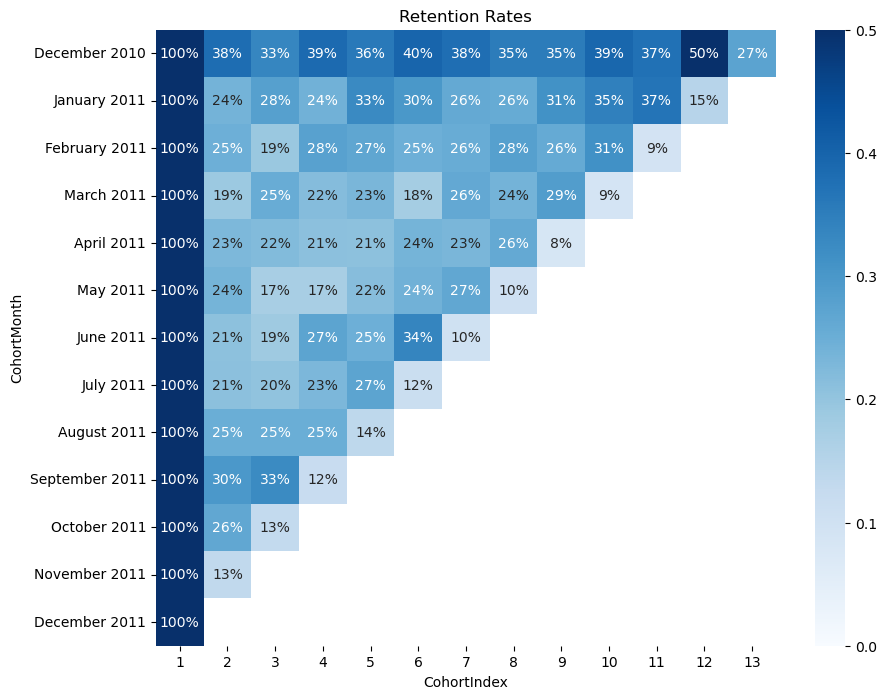

In [22]:
# Visualize new cohort table with percentages (formatted)
retention.index = retention.index
plt.figure(figsize=(10,8))
plt.title('Retention Rates')
sns.heatmap(data=retention, annot=True, cmap='Blues', fmt='.0%', vmin=0.0, vmax=0.5)

In [15]:
#OTHER METRICS (AVERAGE QUANTITY FOR EACH COHORT) -- FROM DATACAMP COURSE 5 MRKETING TRACK
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_avg = grouping['Quantity'].mean()
cohort_data_avg = cohort_data_avg.reset_index()
average_quantity = cohort_data_avg.pivot(index= 'CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


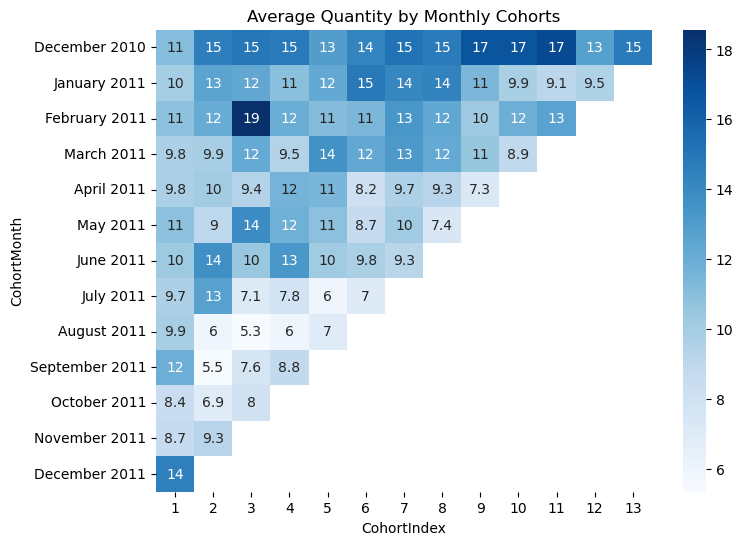

In [26]:
# Visualise the Average quantity

# Change index because it doesn't look nice --> 2010-02-01T00:00:00:0000000000 %B =Month, %Y=Year
#average_quantity.index = average_quantity.index.strftime('%B %Y') 
# Note: comment out the code above because it has already run once. 
# If we run it again, it will throw an error becasue it's no longer a datetime object, so it's inactive.
plt.figure(figsize=(8, 6))
plt.title('Average Quantity by Monthly Cohorts')

sns.heatmap(average_quantity, annot=True, cmap='Blues')
plt.show()